In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append("../")
from src.data import data_preprocessing_from_yahoo_finance

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
stock_data = np.load('../data/processed/20181004_1.npy')
stock_data[np.where(stock_data == 0)] = 1
stock_data_scaled = stock_data[:,1:,:]/stock_data[:,:-1,:]

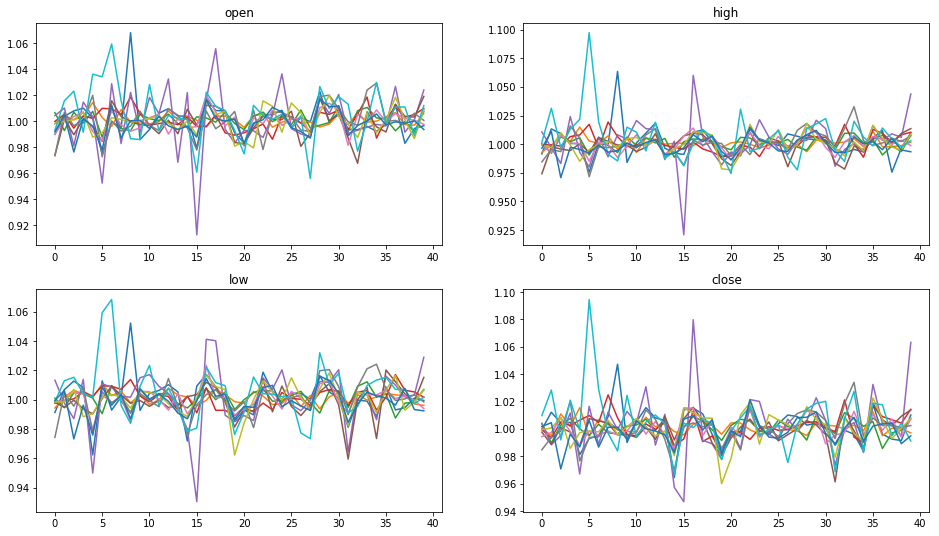

In [3]:
data_preprocessing_from_yahoo_finance.plot_result_np(stock_data_scaled[:,-50:-10,:])

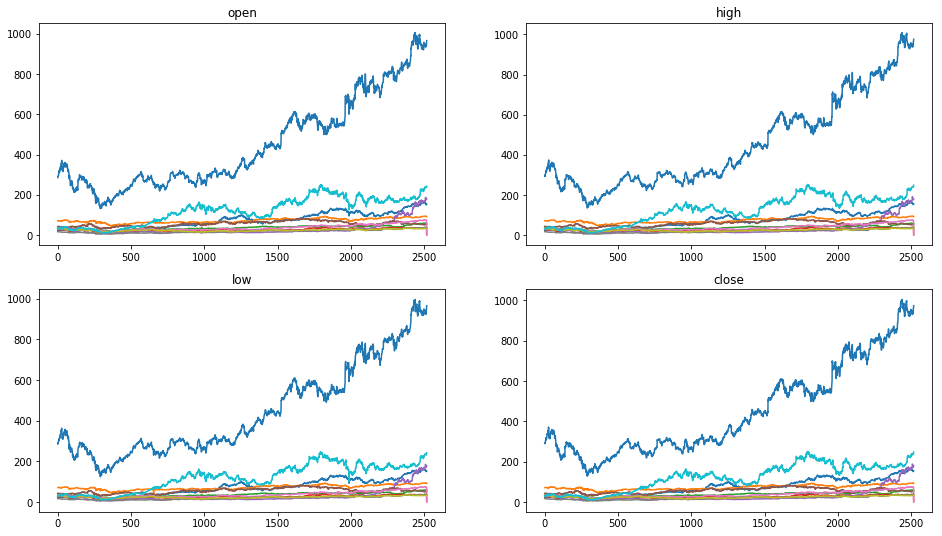

In [4]:
data_preprocessing_from_yahoo_finance.plot_result_np(stock_data)

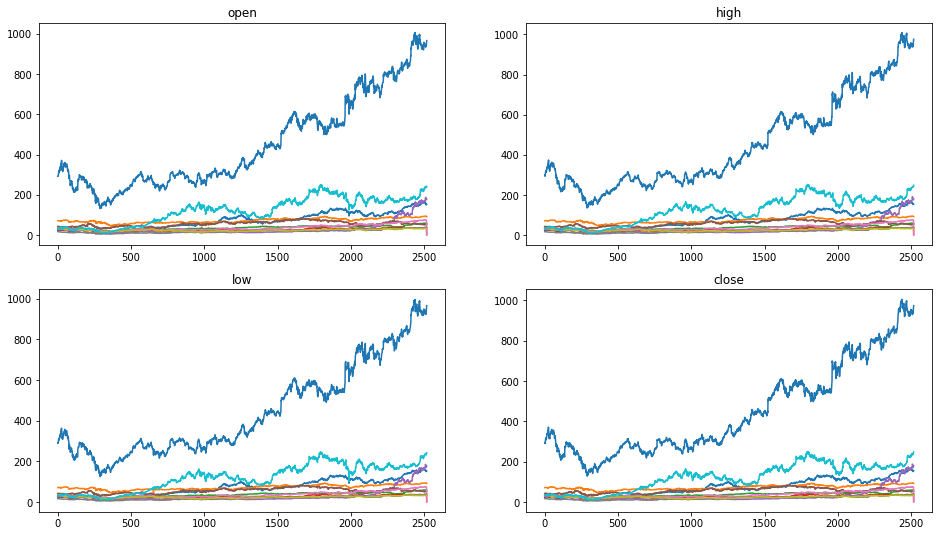

In [5]:
# Re-engineer actual stock price from scaled stock price
test = stock_data[:,0:1,:] * np.cumprod(stock_data_scaled[:,:,:], axis = 1)
data_preprocessing_from_yahoo_finance.plot_result_np(test)

In [6]:
# A simple agent that predict stock price
# Reference : https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html


# Prepare data
train = stock_data_scaled[:,:1999,:]
test = stock_data_scaled[:,2000:,:]

input_size = 100
output_size = 20
# train = [np.array(train[i * self.input_size: (i + 1) * self.input_size])]

train_X = []
train_y = []

for i in range(0, train.shape[1] - input_size - output_size):
    train_X.append(train[:,i:i+input_size,:])
#     if i + output_size == len(train):
#         break

        
for i in range(0, train.shape[1] - input_size - output_size):
    train_y.append(train[:,i+input_size:i+input_size+output_size,:])
#     if i+input_size+output_size == len(train):
#         break
        
        
        
test_X = []
test_y = []

for i in range(0, test.shape[1] - input_size - output_size):
    test_X.append(test[:,i:i+input_size,:])
#     if i + output_size == len(train):
#         break

        
for i in range(0, test.shape[1] - input_size - output_size):
    test_y.append(test[:,i+input_size:i+input_size+output_size,:])

train_X = np.stack(train_X, axis=0)
train_y = np.stack(train_y, axis=0)

test_X = np.stack(test_X, axis=0)
test_y = np.stack(test_y, axis=0)




In [7]:
len(train_X) == len(train_y)

np.concatenate((train_X[0], train_y[0]), axis=1) == train[:,:120,:]



array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [221]:
test_X

[]

In [8]:
print(train_X[-1].shape)
print(train_y[-1].shape)

(4, 100, 11)
(4, 20, 11)


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import ConvLSTM2D #https://keras.io/layers/recurrent/#convlstm2d

Using TensorFlow backend.


In [10]:
# model = Sequential()
# model.add(ConvLSTM2D(50, input_shape=(None, 4, input_size, 11),
#                     kernel_size = 2, strides=(10, 1)))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

# history = model.fit(train_X, train_y, epochs=50, 
#                     batch_size=72, validation_data=(test_X, test_y),
#                     verbose=2, shuffle=True)

ValueError: Error when checking input: expected conv_lst_m2d_1_input to have 5 dimensions, but got array with shape (1879, 4, 100, 11)

In [11]:
from keras.layers import Conv2D, Conv3D
from keras.layers import MaxPooling2D, Flatten
out = 4*20*11
model = Sequential()
model.add(Conv2D(32, kernel_size=(10, 1), strides=(1, 1),
                 activation='relu',
                 input_shape=(4, 100, 11),
                data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(5, 1), strides=(1, 1)))
model.add(Conv2D(64, (5, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation=None))
model.add(Dense(out, activation=None))
model.compile(loss='mae', optimizer='adam')


In [12]:
# train_y2 = [train_y_i.reshape(out,) for train_y_i in train_y]
train_y2 = train_y.reshape((train_y.shape[0], out))
test_y2 = test_y.reshape((test_y.shape[0], out))

In [13]:
history = model.fit(train_X, train_y2, epochs=50, 
                    batch_size=72, validation_data=(test_X, test_y2),
                    verbose=2, shuffle=True)

Train on 1879 samples, validate on 398 samples
Epoch 1/50
 - 19s - loss: 0.7156 - val_loss: 0.0692
Epoch 2/50
 - 15s - loss: 0.0545 - val_loss: 0.0307
Epoch 3/50
 - 15s - loss: 0.0482 - val_loss: 0.0197
Epoch 4/50
 - 15s - loss: 0.0451 - val_loss: 0.0210
Epoch 5/50
 - 15s - loss: 0.0506 - val_loss: 0.0217
Epoch 6/50
 - 15s - loss: 0.0276 - val_loss: 0.0414
Epoch 7/50
 - 15s - loss: 0.0265 - val_loss: 0.0258
Epoch 8/50
 - 15s - loss: 0.0260 - val_loss: 0.0345
Epoch 9/50
 - 15s - loss: 0.0302 - val_loss: 0.0240
Epoch 10/50
 - 15s - loss: 0.0263 - val_loss: 0.0242
Epoch 11/50
 - 15s - loss: 0.0297 - val_loss: 0.0250
Epoch 12/50
 - 15s - loss: 0.0247 - val_loss: 0.0194
Epoch 13/50
 - 15s - loss: 0.0306 - val_loss: 0.0306
Epoch 14/50
 - 15s - loss: 0.0438 - val_loss: 0.0253
Epoch 15/50
 - 15s - loss: 0.0268 - val_loss: 0.0354
Epoch 16/50
 - 15s - loss: 0.0284 - val_loss: 0.0219
Epoch 17/50
 - 15s - loss: 0.0264 - val_loss: 0.0349
Epoch 18/50
 - 15s - loss: 0.0288 - val_loss: 0.0184
Epoch 19

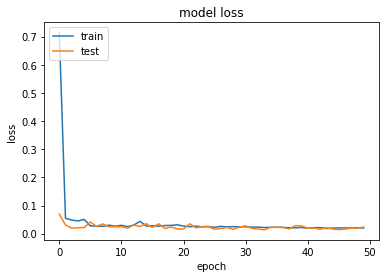

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
testing_result_0 = model.predict(test_X).reshape(398, 4, 20, 11)[0,:,:,:]
testing_result_0_cumprod = np.cumprod(testing_result_0 , axis=1)
testing_result_0_cumprod_plot = test_X[0,:,-2:-1,:] * testing_result_0_cumprod 

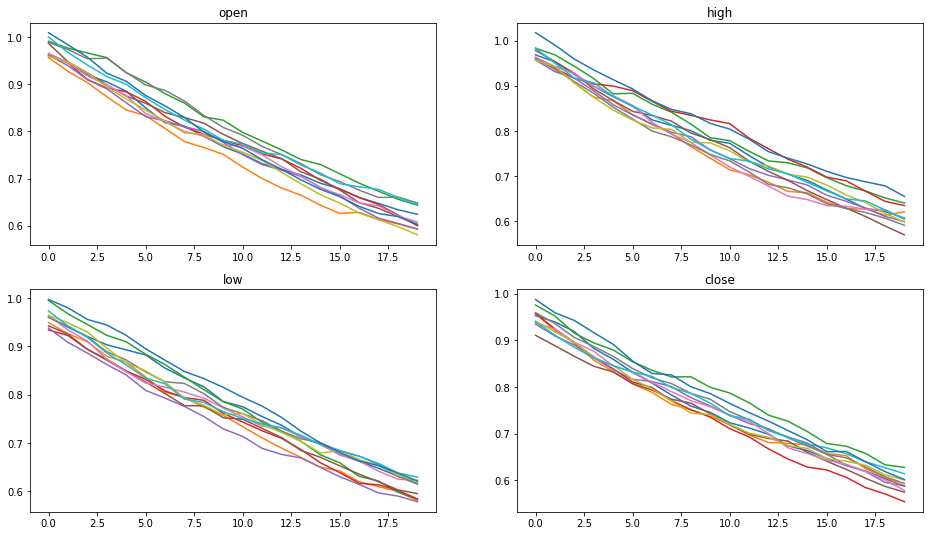

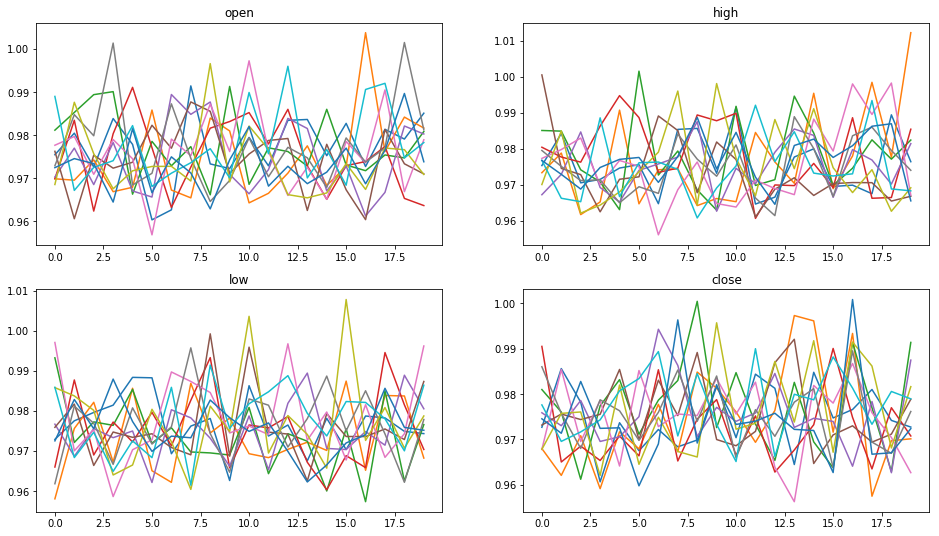

In [19]:
data_preprocessing_from_yahoo_finance.plot_result_np(testing_result_0_cumprod_plot)
data_preprocessing_from_yahoo_finance.plot_result_np(testing_result_0)

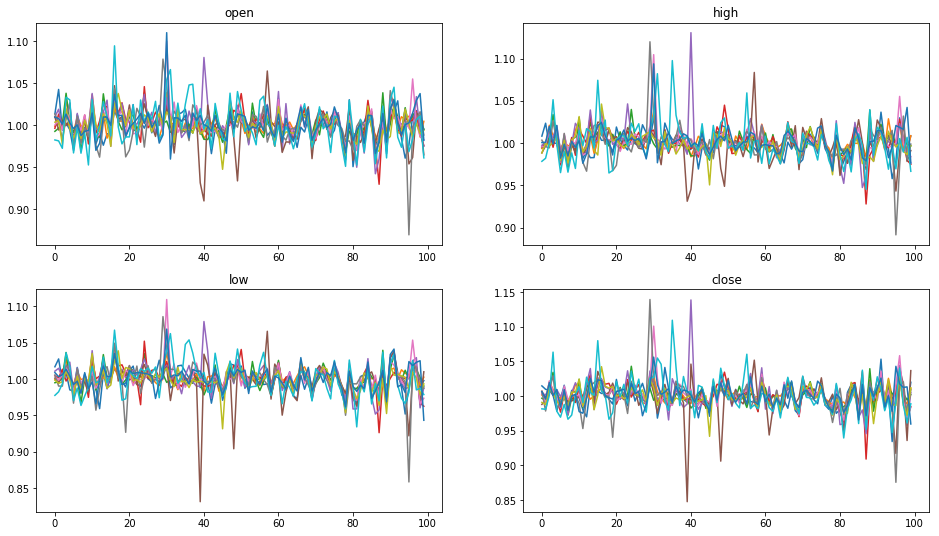

In [17]:
data_preprocessing_from_yahoo_finance.plot_result_np(test_X[0,:,:,:])

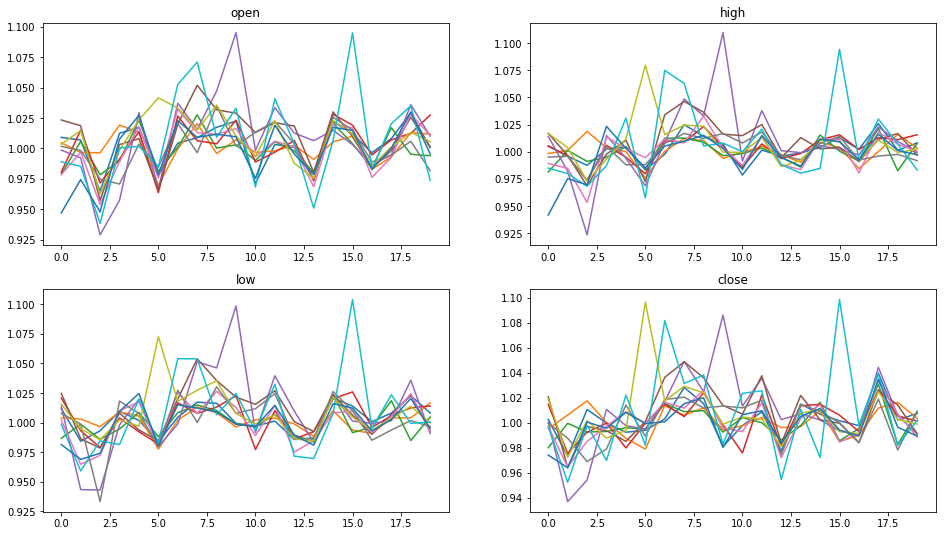

In [18]:
data_preprocessing_from_yahoo_finance.plot_result_np(test_y[0,:,:,:])

In [236]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1879, 4, 100, 11) (1879, 4, 20, 11) (398, 4, 100, 11) (398, 4, 20, 11)
